ORIGINAL DATA SOURCE:

The dataset contains 2 folders - Infected - Uninfected

And a total of 27,558 images.

Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

%matplotlib inline

In [4]:
my_data_dir='..\\data\\cell_images'

In [6]:
os.listdir(my_data_dir) 

['test', 'train']

In [7]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [8]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [9]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [10]:
os.listdir(train_path+'\\parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [11]:
para_cell = train_path+'\\parasitized'+'\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [12]:
para_img= imread(para_cell)

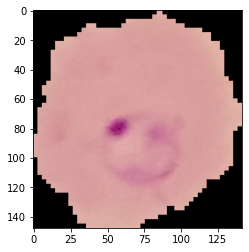

In [13]:
plt.imshow(para_img)

In [14]:
para_img.shape

(148, 142, 3)

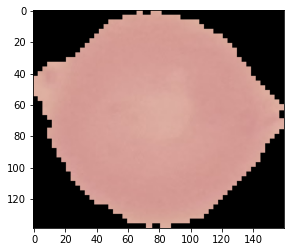

In [15]:
unifected_cell_path = train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

In [16]:
len(os.listdir(train_path+'\\parasitized'))

12480

In [17]:
len(os.listdir(train_path+'\\uninfected'))

12480

In [18]:
unifected_cell.shape

(139, 160, 3)

In [19]:
para_img.shape

(148, 142, 3)

In [20]:
# https://stackoverflow.com/questions/1507084/how-to-check-dimensions-of-all-images-in-a-directory-using-python
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\uninfected'):
    
    img = imread(test_path+'\\uninfected'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

C:\Anaconda3\envs\diabetes\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


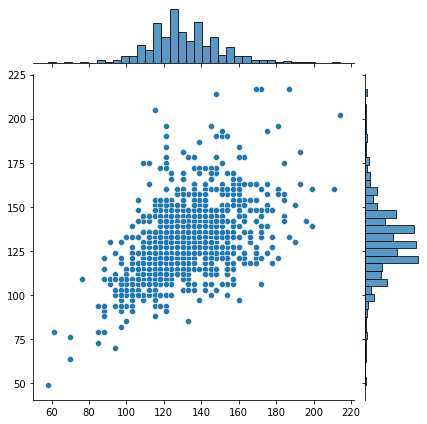

In [21]:
sns.jointplot(dim1,dim2)

In [22]:
np.mean(dim1)

130.92538461538462

In [23]:
np.mean(dim2)

130.75

In [24]:
image_shape = (130,130,3)

## Preparing the Data for the model

### Image Manipulation
Manipulating images with rotation, resizing, and scaling so the model becomes more robust to different images.

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
#help(ImageDataGenerator)

In [27]:
image_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.10, 
                               height_shift_range=0.10, 
                               rescale=1/255, 
                               shear_range=0.1, 
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest'
                              )

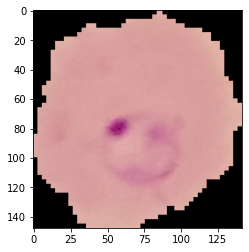

In [28]:
plt.imshow(para_img)

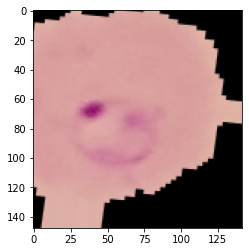

In [29]:
plt.imshow(image_gen.random_transform(para_img))

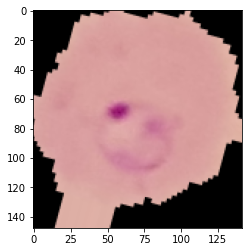

In [30]:
plt.imshow(image_gen.random_transform(para_img))

### Generating many manipulated images from a directory

In [31]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [32]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Creating the Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [34]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

## Early Stopping

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [38]:
#help(image_gen.flow_from_directory)

In [39]:
batch_size = 16

In [40]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [41]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [42]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
#results = model.fit_generator(train_image_gen,epochs=20, validation_data=test_image_gen, callbacks=[early_stop])

In [52]:
from tensorflow.keras.models import load_model
model=load_model('malaria_detector.h5')

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

# Evaluating the Model

In [55]:
#losses = pd.DataFrame(model.history.history)

In [56]:
#losses[['loss','val_loss']].plot()

In [57]:
model.metrics_names

['loss', 'accuracy']

In [58]:
model.evaluate_generator(test_image_gen)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.15221990644931793, 0.947692334651947]

In [59]:
from tensorflow.keras.preprocessing import image

In [60]:
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict_generator(test_image_gen)

Instructions for updating:
Please use Model.predict, which supports generators.


In [61]:
pred_probabilities

array([[1.0655522e-03],
       [5.3831649e-05],
       [3.6077499e-03],
       ...,
       [9.7776318e-01],
       [9.9409842e-01],
       [9.8580098e-01]], dtype=float32)

In [62]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [63]:
predictions = pred_probabilities > 0.5

In [64]:
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [65]:
from sklearn.metrics import classification_report,confusion_matrix

In [66]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1300
           1       0.94      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [67]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1219,   81],
       [  49, 1251]], dtype=int64)

# Predicting on an Image

In [68]:
para_cell

'..\\data\\cell_images\\train\\\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [69]:
my_image = image.load_img(para_cell,target_size=image_shape)

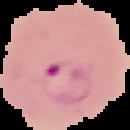

In [70]:
my_image

In [71]:
type(my_image)

PIL.Image.Image

In [72]:
my_image = image.img_to_array(my_image)

In [73]:
type(my_image)

numpy.ndarray

In [74]:
my_image.shape

(130, 130, 3)

In [75]:
my_image = np.expand_dims(my_image, axis=0)

In [76]:
my_image.shape

(1, 130, 130, 3)

In [77]:
model.predict(my_image)

array([[0.]], dtype=float32)

In [148]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}